# US Accidents Big Data Classification  

🟦 CELL 2 — Import Spark & Start Session


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder \
    .appName("US-Accidents-BigData") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

spark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/archive (1).zip" -d /content/


Archive:  /content/drive/MyDrive/archive (1).zip
replace /content/US_Accidents_March23.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
path = "/content/US_Accidents_March23.csv"

df = spark.read.option("header", True).option("inferSchema", True).csv(path)

print("Rows:", df.count())
print("Columns:", len(df.columns))
df.printSchema()


Rows: 4036713
Columns: 46
root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): doubl

🟦 CELL 4 — Pandas vs Spark Load Time (Big Data Proof)

In [ ]:
import time
import pandas as pd

start = time.time()
pd_df = pd.read_csv(path)
print("Pandas load time:", time.time() - start)

start = time.time()
spark.read.csv(path, header=True).count()
print("Spark load time:", time.time() - start)


Pandas load time: 57.80483341217041
Spark load time: 7.1511383056640625


🟦 CELL 5 — Severity Distribution

In [ ]:
total = df.count()

severity_dist = (
    df.groupBy("Severity")
      .count()
      .withColumn("pct", F.round(F.col("count")*100/total,2))
      .orderBy("Severity")
)

severity_dist.show()


+--------+-------+-----+
|Severity|  count|  pct|
+--------+-------+-----+
|       1|  39160| 0.97|
|       2|2764253|68.48|
|       3|1179707|29.22|
|       4|  53593| 1.33|
+--------+-------+-----+



🟦 CELL 6 — Severity Plot

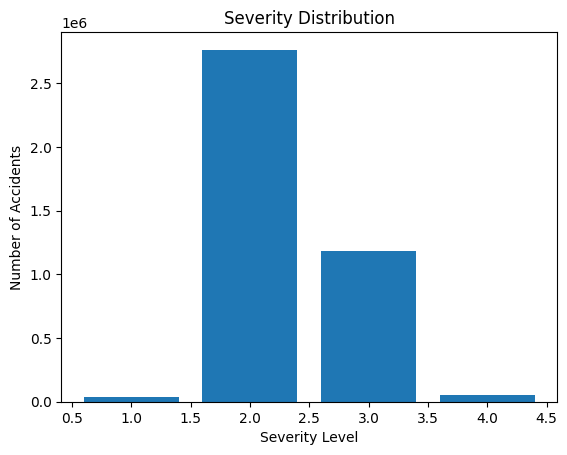

In [ ]:
import matplotlib.pyplot as plt

pdf = severity_dist.toPandas()

plt.bar(pdf["Severity"], pdf["count"])
plt.title("Severity Distribution")
plt.xlabel("Severity Level")
plt.ylabel("Number of Accidents")
plt.show()


🟦 CELL 7 — Missing Value Heatmap

In [ ]:
missing = df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df.columns
]).toPandas().T

missing.columns = ["missing"]
missing["pct"] = (missing["missing"]/total)*100
missing.sort_values("pct", ascending=False).head(10)


,missing,pct
End_Lng,3402762,84.295366
End_Lat,3402762,84.295366
Precipitation(in),1803459,44.676424
Wind_Chill(F),1676962,41.542760
Wind_Speed(mph),414336,10.264193
Visibility(mi),81459,2.017954
Weather_Condition,80081,1.983817
Humidity(%),76806,1.902687
Temperature(F),71976,1.783035
Wind_Direction,68694,1.701731


from matplotlib import pyplot as plt
_df_0['missing'].plot(kind='hist', bins=20, title='missing')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['pct'].plot(kind='hist', bins=20, title='pct')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='missing', y='pct', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['missing'].plot(kind='line', figsize=(8, 4), title='missing')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['pct'].plot(kind='line', figsize=(8, 4), title='pct')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_5['missing'].plot(kind='hist', bins=20, title='missing')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['pct'].plot(kind='hist', bins=20, title='pct')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='missing', y='pct', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['missing'].plot(kind='line', figsize=(8, 4), title='missing')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['pct'].plot(kind='line', figsize=(8, 4), title='pct')
plt.gca().spines[['top', 'right']].set_visible(False)

🟦 CELL 8 — Drop High-Missing Columns

In [ ]:
df = df.drop("End_Lat", "End_Lng")


🟦 CELL 9 — Time Feature Engineering

In [ ]:
df = df.withColumn("Hour", F.hour("Start_Time")) \
       .withColumn("DayOfWeek", F.dayofweek("Start_Time")) \
       .withColumn("Month", F.month("Start_Time"))


🟦 CELL 10 — Impute Numeric Missing

In [ ]:
num_cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
            "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Wind_Chill(F)"]

for c in num_cols:
    median = df.approxQuantile(c,[0.5],0.01)[0]
    df = df.fillna({c: median})


🟦 CELL 11 — Fill Categorical Missing

In [ ]:
cat_cols = ["Weather_Condition","Wind_Direction","Sunrise_Sunset","Civil_Twilight",
            "Nautical_Twilight","Astronomical_Twilight"]

for c in cat_cols:
    df = df.fillna({c:"Unknown"})


🟦 CELL 12 — Save Clean Data (Parquet)

In [ ]:
df.write.mode("overwrite").parquet("/content/cleaned_us_accidents")

🟦 CELL 14 — Load Cleaned Data + Create SQL View

In [ ]:
df = spark.read.parquet("/content/cleaned_us_accidents")

df.createOrReplaceTempView("accidents")
print("View created: accidents")
print("Rows:", df.count(), "Cols:", len(df.columns))


View created: accidents
Rows: 4036713 Cols: 47


🟦 CELL 15 — SQL Query 1 (Markdown)

## SQL Query 1 — Top States by Accident Count (with severity mix)
Purpose:
- Aggregation + grouping
- Identify high-accident states and severity distribution


🟦 CELL 16 — SQL Query 1

In [ ]:
q1 = spark.sql("""
SELECT
  State,
  COUNT(*) AS total_accidents,
  SUM(CASE WHEN Severity = 1 THEN 1 ELSE 0 END) AS sev1,
  SUM(CASE WHEN Severity = 2 THEN 1 ELSE 0 END) AS sev2,
  SUM(CASE WHEN Severity = 3 THEN 1 ELSE 0 END) AS sev3,
  SUM(CASE WHEN Severity = 4 THEN 1 ELSE 0 END) AS sev4
FROM accidents
GROUP BY State
ORDER BY total_accidents DESC
LIMIT 10
""")

q1.show(truncate=False)


+-----+---------------+----+------+------+----+
|State|total_accidents|sev1|sev2  |sev3  |sev4|
+-----+---------------+----+------+------+----+
|CA   |795907         |4745|529990|257537|3635|
|TX   |397134         |3290|284315|107276|2253|
|FL   |356726         |4143|253303|95708 |3572|
|SC   |253284         |6111|204388|41672 |1113|
|NC   |208756         |3350|176597|26761 |2048|
|NY   |186984         |542 |120305|63582 |2555|
|PA   |141441         |1549|107904|28264 |3724|
|VA   |124962         |1399|71961 |47677 |3925|
|IL   |120516         |1371|75195 |42686 |1264|
|GA   |108923         |628 |47602 |56536 |4157|
+-----+---------------+----+------+------+----+



🟦 CELL 17 — Chart: Top 10 States by Total Accidents

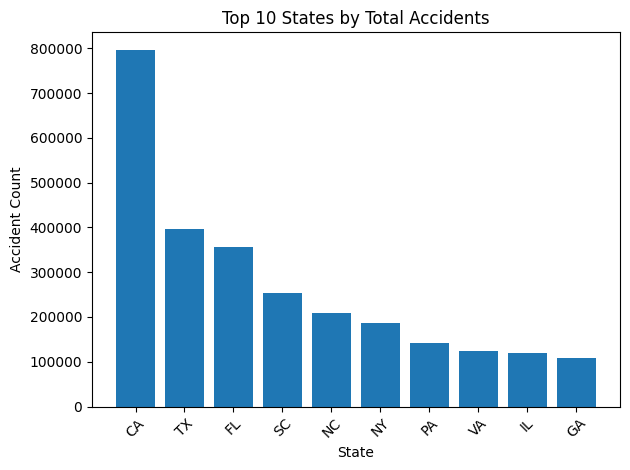

In [ ]:
import matplotlib.pyplot as plt

q1_pd = q1.toPandas()

plt.figure()
plt.bar(q1_pd["State"], q1_pd["total_accidents"])
plt.title("Top 10 States by Total Accidents")
plt.xlabel("State")
plt.ylabel("Accident Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


🟦 CELL 18 — SQL Query 2 (Markdown)

## SQL Query 2 — Accidents by Hour (Time Pattern)
Purpose:
- Grouping by engineered time feature (Hour)
- Show daily risk pattern


🟦 CELL 19 — SQL Query 2

In [ ]:
q2 = spark.sql("""
SELECT
  Hour,
  COUNT(*) AS accidents_count
FROM accidents
WHERE Hour IS NOT NULL
GROUP BY Hour
ORDER BY Hour
""")

q2.show(30, truncate=False)


+----+---------------+
|Hour|accidents_count|
+----+---------------+
|0   |26043          |
|1   |22717          |
|2   |23802          |
|3   |23938          |
|4   |97067          |
|5   |129364         |
|6   |259221         |
|7   |402889         |
|8   |407186         |
|9   |224597         |
|10  |208252         |
|11  |205708         |
|12  |170136         |
|13  |180071         |
|14  |194400         |
|15  |238312         |
|16  |291633         |
|17  |291886         |
|18  |220685         |
|19  |147543         |
|20  |102381         |
|21  |75276          |
|22  |61864          |
|23  |31742          |
+----+---------------+



🟦 CELL 20 — Chart: Accidents by Hour

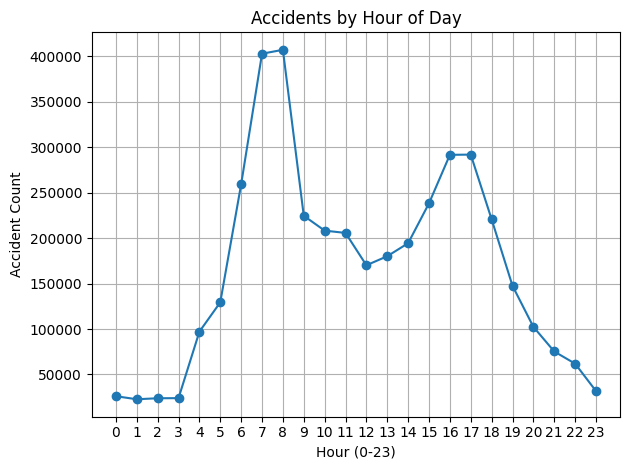

In [ ]:
q2_pd = q2.toPandas()

plt.figure()
plt.plot(q2_pd["Hour"], q2_pd["accidents_count"], marker="o")
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour (0-23)")
plt.ylabel("Accident Count")
plt.xticks(range(0,24))
plt.grid(True)
plt.tight_layout()
plt.show()


🟦 CELL 21 — SQL Query 3 (Markdown)
## SQL Query 3 — Weather Condition vs Severity (Top conditions)
Purpose:
- Filtering + grouping
- Analyze severity mix under common weather conditions


🟦 CELL 22 — SQL Query 3

In [ ]:
q3 = spark.sql("""
SELECT
  Weather_Condition,
  COUNT(*) AS total,
  ROUND(AVG(Severity), 3) AS avg_severity,
  SUM(CASE WHEN Severity >= 3 THEN 1 ELSE 0 END) AS high_sev_cnt,
  ROUND(100.0 * SUM(CASE WHEN Severity >= 3 THEN 1 ELSE 0 END) / COUNT(*), 2) AS high_sev_pct
FROM accidents
WHERE Weather_Condition IS NOT NULL
  AND Weather_Condition <> 'Unknown'
GROUP BY Weather_Condition
HAVING COUNT(*) >= 5000
ORDER BY total DESC
LIMIT 12
""")

q3.show(truncate=False)


+-----------------+------+------------+------------+------------+
|Weather_Condition|total |avg_severity|high_sev_cnt|high_sev_pct|
+-----------------+------+------------+------------+------------+
|Fair             |943294|2.23        |226678      |24.03       |
|Clear            |713704|2.351       |239519      |33.56       |
|Mostly Cloudy    |555085|2.319       |176824      |31.86       |
|Partly Cloudy    |381303|2.313       |119370      |31.31       |
|Overcast         |331962|2.363       |115401      |34.76       |
|Cloudy           |322723|2.264       |85696       |26.55       |
|Light Rain       |193360|2.353       |66649       |34.47       |
|Scattered Clouds |181533|2.367       |64094       |35.31       |
|Light Snow       |57918 |2.382       |21002       |36.26       |
|Rain             |46002 |2.383       |17229       |37.45       |
|Fog              |45201 |2.206       |9261        |20.49       |
|Haze             |38945 |2.349       |13503       |34.67       |
+---------

🟦 CELL 23 — Chart: High Severity % by Weather Condition

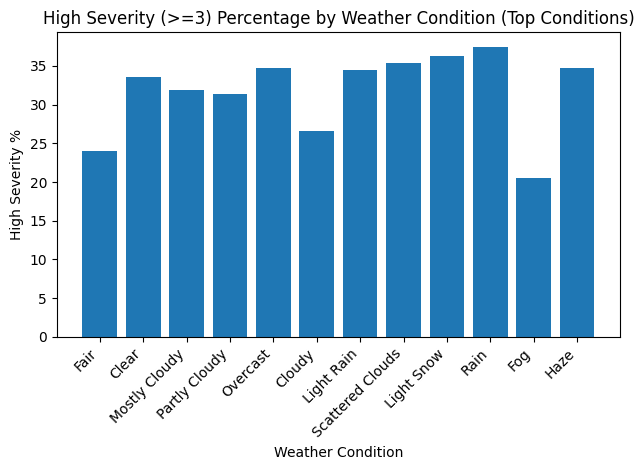

In [ ]:
q3_pd = q3.toPandas()

plt.figure()
plt.bar(q3_pd["Weather_Condition"], q3_pd["high_sev_pct"])
plt.title("High Severity (>=3) Percentage by Weather Condition (Top Conditions)")
plt.xlabel("Weather Condition")
plt.ylabel("High Severity %")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


🟦 CELL 24 — SQL Query 4 (Markdown)
## (Optional) SQL Query 4 — Accidents by Day of Week
Purpose:
- Another time-based pattern for presentation


🟦 CELL 25 — SQL Query 4 + Chart

+---------+---------------+
|DayOfWeek|accidents_count|
+---------+---------------+
|1        |212142         |
|2        |683010         |
|3        |724652         |
|4        |726931         |
|5        |718155         |
|6        |730637         |
|7        |241186         |
+---------+---------------+



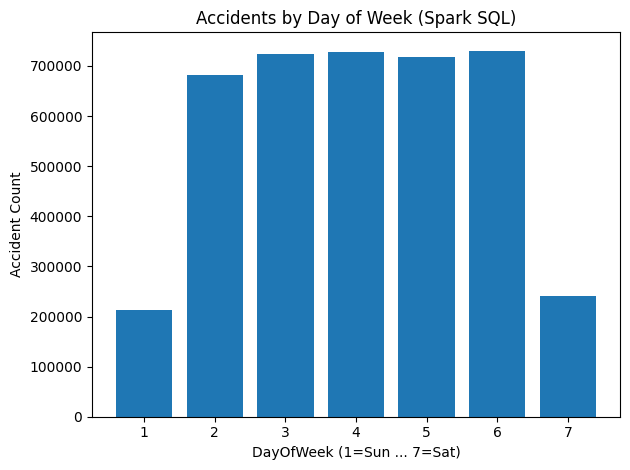

In [ ]:
q4 = spark.sql("""
SELECT
  DayOfWeek,
  COUNT(*) AS accidents_count
FROM accidents
WHERE DayOfWeek IS NOT NULL
GROUP BY DayOfWeek
ORDER BY DayOfWeek
""")

q4.show(truncate=False)

q4_pd = q4.toPandas()

plt.figure()
plt.bar(q4_pd["DayOfWeek"], q4_pd["accidents_count"])
plt.title("Accidents by Day of Week (Spark SQL)")
plt.xlabel("DayOfWeek (1=Sun ... 7=Sat)")
plt.ylabel("Accident Count")
plt.tight_layout()
plt.show()


# Part 3 Summary (for Report / Slides)

We created a Spark SQL view and executed analytical queries:
1) Top states by accident counts and severity distribution  
2) Accidents by hour of day (peak risk periods)  
3) Weather conditions vs severity (high severity ratio)  
(Optional) Accidents by day of week

Charts produced:
- Top states by accidents (bar)
- Accidents by hour (line)
- High severity % by weather condition (bar)
- Accidents by weekday (bar)


🟦 CELL 28 — Select Features for ML

In [ ]:
feature_cols = [
    "Distance(mi)",
    "Temperature(F)",
    "Humidity(%)",
    "Pressure(in)",
    "Visibility(mi)",
    "Wind_Speed(mph)",
    "Precipitation(in)",
    "Wind_Chill(F)",
    "Hour",
    "DayOfWeek",
    "Month",
    "Traffic_Signal",
    "Crossing",
    "Junction",
    "Stop",
    "Amenity",
    "Railway",
    "Roundabout",
    "Station"
]


🟦 CELL 29 — Handle Boolean Columns

In [ ]:
from pyspark.sql.types import IntegerType

for c in ["Traffic_Signal","Crossing","Junction","Stop","Amenity","Railway","Roundabout","Station"]:
    df = df.withColumn(c, F.col(c).cast(IntegerType()))


🟦 CELL 30 — Categorical Encoding

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

indexer = StringIndexer(inputCol="Weather_Condition", outputCol="Weather_Condition_idx")
df = indexer.fit(df).transform(df)

encoder = OneHotEncoder(inputCol="Weather_Condition_idx", outputCol="Weather_Condition_vec")
df = encoder.fit(df).transform(df)


🟦 CELL 31 — Vector Assembler

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=feature_cols + ["Weather_Condition_vec"],
    outputCol="features"
)

df = assembler.transform(df)


🟦 CELL 32 — Create Class Weights

In [ ]:
total = df.count()

dist = df.groupBy("Severity").count().toPandas()

weights = {row["Severity"]: total / row["count"] for _, row in dist.iterrows()}
weights


{np.int64(3): np.float64(3.4217928689072794),
 np.int64(1): np.float64(103.08255873340143),
 np.int64(2): np.float64(1.46032689482475),
 np.int64(4): np.float64(75.32164648368257)}

🟦 CELL 33 — Add Weight Column

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

weight_udf = udf(lambda x: float(weights[x]), DoubleType())

df = df.withColumn("classWeight", weight_udf(F.col("Severity")))


🟦 CELL 34 — Train / Test Split

In [ ]:
train, test = df.randomSplit([0.8, 0.2], seed=42)

print("Train:", train.count())
print("Test:", test.count())


Train: 3229739
Test: 806974


🟦 CELL 35 — Train Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features",
    labelCol="Severity",
    weightCol="classWeight",
    maxIter=30
)

model = lr.fit(train)


🟦 CELL 36 — Predict on Test Set

In [ ]:
pred = model.transform(test)
pred.select("Severity","prediction","probability").show(10)


+--------+----------+--------------------+
|Severity|prediction|         probability|
+--------+----------+--------------------+
|       2|       1.0|[7.33404195120616...|
|       2|       1.0|[5.44162147164345...|
|       2|       1.0|[5.44162147164345...|
|       2|       1.0|[4.20586426319858...|
|       2|       1.0|[5.47617562684454...|
|       3|       1.0|[7.26567704278548...|
|       3|       1.0|[7.37258345309667...|
|       4|       4.0|[4.01859288113005...|
|       3|       3.0|[7.37144664399506...|
|       2|       3.0|[7.43326692717099...|
+--------+----------+--------------------+
only showing top 10 rows


🟦 CELL 37 — Evaluation Metrics

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

metrics = {}

for metric in ["accuracy","weightedPrecision","weightedRecall","f1"]:
    evaluator = MulticlassClassificationEvaluator(
        labelCol="Severity",
        predictionCol="prediction",
        metricName=metric
    )
    metrics[metric] = evaluator.evaluate(pred)

metrics


{'accuracy': 0.39976876578427556,
 'weightedPrecision': 0.7041229882621197,
 'weightedRecall': 0.3997687657842756,
 'f1': 0.4479355886307599}

🟦 CELL 38 — Confusion Matrix

In [ ]:
cm = (
    pred.groupBy("Severity","prediction")
        .count()
        .orderBy("Severity","prediction")
)

cm.show(50)


+--------+----------+------+
|Severity|prediction| count|
+--------+----------+------+
|       1|       1.0|  6584|
|       1|       2.0|   467|
|       1|       3.0|   684|
|       1|       4.0|   113|
|       2|       1.0|136992|
|       2|       2.0|164771|
|       2|       3.0|212063|
|       2|       4.0| 38927|
|       3|       1.0| 42057|
|       3|       2.0| 26471|
|       3|       3.0|146201|
|       3|       4.0| 21054|
|       4|       1.0|   869|
|       4|       2.0|  1260|
|       4|       3.0|  3414|
|       4|       4.0|  5047|
+--------+----------+------+



🟦 CELL 39 — Confusion Matrix Plot

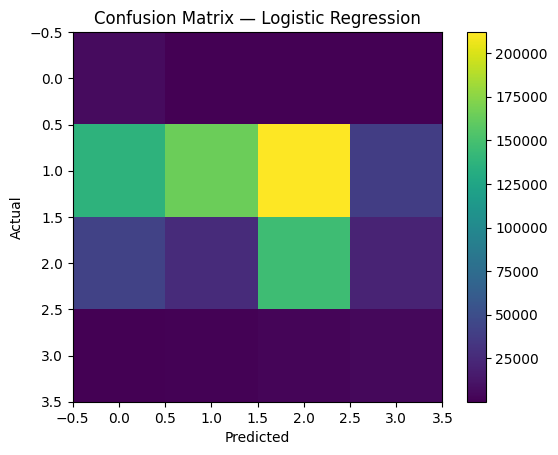

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

cm_pd = cm.toPandas()
pivot = cm_pd.pivot(index="Severity", columns="prediction", values="count").fillna(0)

plt.figure()
plt.imshow(pivot)
plt.colorbar()
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


🟦 CELL 40 — Binary Extension Title (Markdown)

# Part 4 Extension — Binary Classification (High Severity Detection)

We reformulate the problem into a binary classification task:
- label_bin = 1  if Severity >= 3 (High severity)
- label_bin = 0  if Severity <= 2 (Low severity)

This is an additional experiment to compare performance under extreme class imbalance.


🟦 CELL 41 — Create Binary Label

In [ ]:
from pyspark.sql import functions as F

df_bin = df.withColumn(
    "label_bin",
    F.when(F.col("Severity") >= 3, F.lit(1)).otherwise(F.lit(0))
)

df_bin.select("Severity", "label_bin").show(10)


+--------+---------+
|Severity|label_bin|
+--------+---------+
|       2|        0|
|       2|        0|
|       2|        0|
|       2|        0|
|       2|        0|
|       2|        0|
|       2|        0|
|       2|        0|
|       3|        1|
|       2|        0|
+--------+---------+
only showing top 10 rows


🟦 CELL 42 — Binary Class Distribution (Check Imbalance)

In [ ]:
total_bin = df_bin.count()

dist_bin = (
    df_bin.groupBy("label_bin")
          .count()
          .withColumn("pct", F.round(F.col("count") * 100.0 / F.lit(total_bin), 3))
          .orderBy("label_bin")
)

dist_bin.show()


+---------+-------+------+
|label_bin|  count|   pct|
+---------+-------+------+
|        0|2803413|69.448|
|        1|1233300|30.552|
+---------+-------+------+



🟦 CELL 43 — Compute Binary Class Weights

In [ ]:
dist_pd = dist_bin.toPandas()
counts = {int(r["label_bin"]): int(r["count"]) for _, r in dist_pd.iterrows()}

weights_bin = {k: total_bin / v for k, v in counts.items()}
weights_bin


{0: 1.439928044851044, 1: 3.273099002675748}

🟦 CELL 44 — Add Weight Column

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

w_udf = udf(lambda x: float(weights_bin[int(x)]), DoubleType())

df_bin = df_bin.withColumn("classWeight_bin", w_udf(F.col("label_bin")))
df_bin.select("label_bin", "classWeight_bin").show(5)


+---------+-----------------+
|label_bin|  classWeight_bin|
+---------+-----------------+
|        0|1.439928044851044|
|        0|1.439928044851044|
|        0|1.439928044851044|
|        0|1.439928044851044|
|        0|1.439928044851044|
+---------+-----------------+
only showing top 5 rows


🟦 CELL 45 — Train/Test Split (Binary)

In [ ]:
train_b, test_b = df_bin.randomSplit([0.8, 0.2], seed=42)

print("Train:", train_b.count())
print("Test:", test_b.count())


Train: 3229739
Test: 806974


🟦 CELL 46 — Train Binary Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr_bin = LogisticRegression(
    featuresCol="features",
    labelCol="label_bin",
    weightCol="classWeight_bin",
    maxIter=30
)

model_bin = lr_bin.fit(train_b)


🟦 CELL 47 — Predict (Binary)

In [ ]:
pred_b = model_bin.transform(test_b)
pred_b.select("label_bin", "prediction", "probability").show(10, truncate=False)


+---------+----------+----------------------------------------+
|label_bin|prediction|probability                             |
+---------+----------+----------------------------------------+
|0        |0.0       |[0.55456561673226,0.44543438326774]     |
|0        |0.0       |[0.8199846529730647,0.18001534702693534]|
|0        |0.0       |[0.8199846529730647,0.18001534702693534]|
|0        |0.0       |[0.9242030777163657,0.07579692228363433]|
|0        |0.0       |[0.8133600753096433,0.18663992469035673]|
|1        |0.0       |[0.5288629367089377,0.4711370632910623] |
|1        |0.0       |[0.5091108782506033,0.4908891217493967] |
|1        |1.0       |[0.45987736998717416,0.5401226300128259]|
|1        |1.0       |[0.4801734768102895,0.5198265231897106] |
|0        |1.0       |[0.479311819779406,0.520688180220594]   |
+---------+----------+----------------------------------------+
only showing top 10 rows


🟦 CELL 48 — Binary Evaluation (AUC + Accuracy/Precision/Recall/F1)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# AUC (ROC)
auc = BinaryClassificationEvaluator(
    labelCol="label_bin",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
).evaluate(pred_b)

# Accuracy / Precision / Recall / F1
metrics_bin = {}
for metric in ["accuracy", "weightedPrecision", "weightedRecall", "f1"]:
    metrics_bin[metric] = MulticlassClassificationEvaluator(
        labelCol="label_bin",
        predictionCol="prediction",
        metricName=metric
    ).evaluate(pred_b)

print("AUC:", auc)
metrics_bin


AUC: 0.6897227926237722


{'accuracy': 0.5884861222294646,
 'weightedPrecision': 0.7141142935140037,
 'weightedRecall': 0.5884861222294646,
 'f1': 0.600679312432125}

🟦 CELL 49 — Binary Confusion Matrix



In [ ]:
cm_b = (
    pred_b.groupBy("label_bin", "prediction")
          .count()
          .orderBy("label_bin", "prediction")
)

cm_b.show()


+---------+----------+------+
|label_bin|prediction| count|
+---------+----------+------+
|        0|       0.0|278619|
|        0|       1.0|281982|
|        1|       0.0| 50099|
|        1|       1.0|196274|
+---------+----------+------+



🟦 CELL 50 — Confusion Matrix Plot (Binary)

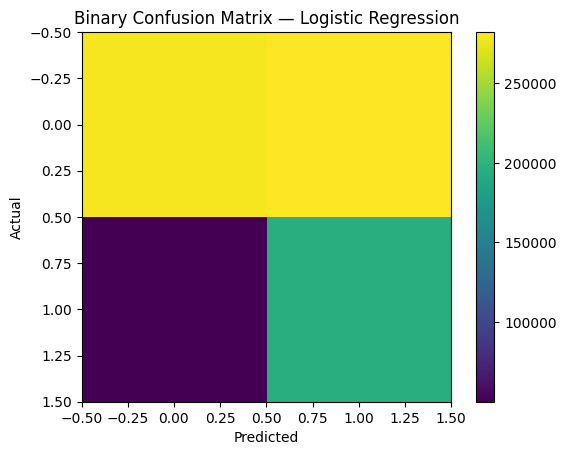

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

cm_pd = cm_b.toPandas()
pivot = cm_pd.pivot(index="label_bin", columns="prediction", values="count").fillna(0)

plt.figure()
plt.imshow(pivot)
plt.colorbar()
plt.title("Binary Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


🟦 CELL 51 — Binary Extension Summary (Markdown)

## Binary Extension Summary

- We converted the original 4-class severity prediction into a binary task:
  High severity (3–4) vs Low severity (1–2).
- We trained a weighted Logistic Regression model to handle imbalance.
- We evaluated using:
  - AUC (ROC)
  - Accuracy
  - Precision
  - Recall
  - F1-score
- This experiment is used for comparison and analysis only (not the main pipeline).


# Part 4 Summary

We trained a Spark MLlib Logistic Regression model with class weights
to handle extreme class imbalance.

Evaluation Metrics:
- Accuracy
- Precision
- Recall
- F1-score

A confusion matrix was generated to visualize prediction quality
for each severity level.


🟦 CELL 52 — Part 5 Title (Markdown)

# Part 5 — ETL Pipeline (Extract → Transform → Load)

Goal:
Automate the workflow as an ETL pipeline:
- Extract: read raw CSV
- Transform: cleaning + feature engineering + encoding + vector assembly + class weights
- Load: save curated Parquet + create Spark SQL table/view for downstream queries/models


🟦 CELL 53 — ETL Config (paths + output)

In [ ]:
RAW_PATH = "/content/US_Accidents_March23.csv"
CURATED_PARQUET_PATH = "/content/curated_us_accidents_parquet"
SQL_VIEW_NAME = "accidents_curated"


🟦 CELL 54 — Extract Function

In [ ]:
from pyspark.sql import functions as F

def extract_raw(path: str):
    df = (spark.read
          .option("header", True)
          .option("inferSchema", True)
          .csv(path))
    return df


🟦 CELL 55 — Transform: drop high-missing + time features

In [ ]:
def transform_step1(df):
    # Drop very high-missing columns
    df = df.drop("End_Lat", "End_Lng")

    # Time feature engineering
    df = (df
          .withColumn("Hour", F.hour("Start_Time"))
          .withColumn("DayOfWeek", F.dayofweek("Start_Time"))
          .withColumn("Month", F.month("Start_Time")))
    return df


🟦 CELL 56 — Transform: imputations (numeric + categorical)

In [ ]:
def transform_step2_impute(df):
    total = df.count()  # used only for sanity; keep once in ETL

    # Numeric columns (median)
    num_cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Wind_Chill(F)"]

    medians = {}
    for c in num_cols:
        # if a column is missing entirely in some versions, guard:
        if c in df.columns:
            med = df.approxQuantile(c, [0.5], 0.01)[0]
            medians[c] = med

    if medians:
        df = df.fillna(medians)

    # Categorical columns
    cat_cols = ["Weather_Condition","Wind_Direction","Sunrise_Sunset","Civil_Twilight",
                "Nautical_Twilight","Astronomical_Twilight"]

    fill_map = {c: "Unknown" for c in cat_cols if c in df.columns}
    if fill_map:
        df = df.fillna(fill_map)

    # Minimal cleanup for essential columns
    df = df.dropna(subset=["Severity", "Start_Time", "Start_Lat", "Start_Lng"])

    return df


🟦 CELL 57 — Transform: cast booleans to int

In [ ]:
from pyspark.sql.types import IntegerType

def transform_step3_booleans(df):
    bool_cols = ["Traffic_Signal","Crossing","Junction","Stop","Amenity",
                 "Railway","Roundabout","Station"]
    for c in bool_cols:
        if c in df.columns:
            df = df.withColumn(c, F.col(c).cast(IntegerType()))
    return df


🟦 CELL 58 — Transform: encode Weather_Condition + assemble features

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

def transform_step4_features(df):
    # Encode Weather_Condition
    if "Weather_Condition" in df.columns:
        indexer = StringIndexer(inputCol="Weather_Condition", outputCol="Weather_Condition_idx", handleInvalid="keep")
        df = indexer.fit(df).transform(df)

        encoder = OneHotEncoder(inputCol="Weather_Condition_idx", outputCol="Weather_Condition_vec")
        df = encoder.fit(df).transform(df)
    else:
        # If missing, create a zero-vector substitute is complex; better to fail early
        raise ValueError("Weather_Condition column not found in dataset.")

    feature_cols = [
        "Distance(mi)",
        "Temperature(F)",
        "Humidity(%)",
        "Pressure(in)",
        "Visibility(mi)",
        "Wind_Speed(mph)",
        "Precipitation(in)",
        "Wind_Chill(F)",
        "Hour",
        "DayOfWeek",
        "Month",
        "Traffic_Signal",
        "Crossing",
        "Junction",
        "Stop",
        "Amenity",
        "Railway",
        "Roundabout",
        "Station"
    ]
    feature_cols = [c for c in feature_cols if c in df.columns]

    assembler = VectorAssembler(
        inputCols=feature_cols + ["Weather_Condition_vec"],
        outputCol="features"
    )
    df = assembler.transform(df)
    return df


🟦 CELL 59 — Transform: class weights column

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def transform_step5_class_weights(df):
    total = df.count()
    dist = df.groupBy("Severity").count().collect()

    weights = {int(r["Severity"]): float(total) / float(r["count"]) for r in dist}

    weight_udf = udf(lambda x: float(weights[int(x)]), DoubleType())
    df = df.withColumn("classWeight", weight_udf(F.col("Severity")))

    return df, weights


🟦 CELL 60 — Load: write curated Parquet + create SQL view

In [ ]:
def load_curated(df, parquet_path: str, view_name: str):
    df.write.mode("overwrite").parquet(parquet_path)
    curated = spark.read.parquet(parquet_path)
    curated.createOrReplaceTempView(view_name)
    return curated


🟦 CELL 61 — Run Full ETL

In [ ]:
raw = extract_raw(RAW_PATH)

t1 = transform_step1(raw)
t2 = transform_step2_impute(t1)
t3 = transform_step3_booleans(t2)
t4 = transform_step4_features(t3)
curated, class_weights = transform_step5_class_weights(t4)

curated = load_curated(curated, CURATED_PARQUET_PATH, SQL_VIEW_NAME)

print("ETL done.")
print("Curated rows:", curated.count())
print("Curated cols:", len(curated.columns))
print("SQL view:", SQL_VIEW_NAME)
print("Class weights:", class_weights)


ETL done.
Curated rows: 4036713
Curated cols: 51
SQL view: accidents_curated
Class weights: {3: 3.4217928689072794, 1: 103.08255873340143, 2: 1.46032689482475, 4: 75.32164648368257}


🟦 CELL 62 — ETL Validation Queries (quick checks)

In [ ]:

spark.sql(f"""
SELECT
  Severity,
  COUNT(*) AS cnt
FROM {SQL_VIEW_NAME}
GROUP BY Severity
ORDER BY Severity
""").show()


spark.sql(f"""
SELECT
  AVG(`Temperature(F)`)   AS avg_temp,
  AVG(`Visibility(mi)`)   AS avg_vis,
  AVG(`Humidity(%)`)      AS avg_humidity,
  AVG(`Pressure(in)`)     AS avg_pressure,
  AVG(`Wind_Speed(mph)`)  AS avg_wind,
  AVG(`Precipitation(in)`) AS avg_precip
FROM {SQL_VIEW_NAME}
""").show()


+--------+-------+
|Severity|    cnt|
+--------+-------+
|       1|  39160|
|       2|2764253|
|       3|1179707|
|       4|  53593|
+--------+-------+

+-----------------+----------------+-----------------+-----------------+-----------------+--------------------+
|         avg_temp|         avg_vis|     avg_humidity|     avg_pressure|         avg_wind|          avg_precip|
+-----------------+----------------+-----------------+-----------------+-----------------+--------------------+
|62.26787609124757|9.11840934938897|65.85362595755507|29.67548235408669|7.818878379509453|0.006641975785749232|
+-----------------+----------------+-----------------+-----------------+-----------------+--------------------+



🟦 CELL 63 — Part 5 Summary (Markdown)

# Part 5 Summary — ETL Pipeline

We implemented an automated ETL pipeline in PySpark:

**Extract**
- Read raw CSV into Spark DataFrame

**Transform**
- Drop high-missing columns (End_Lat, End_Lng)
- Feature engineering from Start_Time (Hour, DayOfWeek, Month)
- Impute missing numeric values using median
- Fill missing categorical values with "Unknown"
- Encode Weather_Condition (StringIndexer + OneHotEncoder)
- Assemble model features into a single vector
- Handle class imbalance with computed class weights

**Load**
- Save curated dataset to Parquet
- Register curated data as Spark SQL view for reuse


🟦 Part 6 — Advanced Extension: Anomaly Detection (Z-Score)

🟦 CELL 64 — Part 6 Title (Markdown)

# Part 6 — Advanced Extension: Anomaly Detection (Z-Score)

Approach:
- Use Z-score on selected numerical features
- Detect extreme outliers as anomalies
- Output: top anomalies + charts for presentation


🟦 CELL 65 — Select Numeric Columns + Basic Stats

In [ ]:
VIEW = "accidents_curated"

num_cols = [
    "Distance(mi)",
    "Precipitation(in)",
    "Wind_Speed(mph)",
    "Visibility(mi)",
    "Temperature(F)",
    "Pressure(in)",
    "Humidity(%)"
]

# Keep only columns that exist
existing_num_cols = [c for c in num_cols if c in spark.table(VIEW).columns]
existing_num_cols


['Distance(mi)',
 'Precipitation(in)',
 'Wind_Speed(mph)',
 'Visibility(mi)',
 'Temperature(F)',
 'Pressure(in)',
 'Humidity(%)']

🟦 CELL 66 — Compute Mean/Std for Z-score

In [ ]:
stats_expr = []
for c in existing_num_cols:
    stats_expr += [
        F.mean(F.col(c)).alias(f"{c}__mean"),
        F.stddev(F.col(c)).alias(f"{c}__std")
    ]

stats_row = spark.table(VIEW).select(*stats_expr).collect()[0].asDict()
stats_row


{'Distance(mi)__mean': 0.31931348155363865,
 'Distance(mi)__std': 1.7092535923946128,
 'Precipitation(in)__mean': 0.006641975785749232,
 'Precipitation(in)__std': 0.11513085637360618,
 'Wind_Speed(mph)__mean': 7.818878379509453,
 'Wind_Speed(mph)__std': 5.003828900420776,
 'Visibility(mi)__mean': 9.11840934938897,
 'Visibility(mi)__std': 2.7043744188325287,
 'Temperature(F)__mean': 62.26787609124757,
 'Temperature(F)__std': 18.530499263049794,
 'Pressure(in)__mean': 29.67548235408669,
 'Pressure(in)__std': 0.8574811439841571,
 'Humidity(%)__mean': 65.85362595755507,
 'Humidity(%)__std': 22.342834626739446}

🟦 CELL 67 — Build Z-score Columns

In [ ]:
df_cur = spark.table(VIEW)

for c in existing_num_cols:
    mu = stats_row.get(f"{c}__mean")
    sd = stats_row.get(f"{c}__std")
    if sd is None or sd == 0:
        df_cur = df_cur.withColumn(f"z_{c}", F.lit(0.0))
    else:
        df_cur = df_cur.withColumn(f"z_{c}", (F.col(c) - F.lit(mu)) / F.lit(sd))

df_cur.select(existing_num_cols + [f"z_{c}" for c in existing_num_cols]).show(5, truncate=False)


+------------+-----------------+---------------+--------------+--------------+------------+-----------+---------------------+--------------------+--------------------+-------------------+---------------------+------------------+---------------------+
|Distance(mi)|Precipitation(in)|Wind_Speed(mph)|Visibility(mi)|Temperature(F)|Pressure(in)|Humidity(%)|z_Distance(mi)       |z_Precipitation(in) |z_Wind_Speed(mph)   |z_Visibility(mi)   |z_Temperature(F)     |z_Pressure(in)    |z_Humidity(%)        |
+------------+-----------------+---------------+--------------+--------------+------------+-----------+---------------------+--------------------+--------------------+-------------------+---------------------+------------------+---------------------+
|0.241       |0.0              |12.7           |10.0          |55.9          |30.23       |60.0       |-0.04581735671178191 |-0.05769066603826556|0.9754773229916173  |0.32598690642533495|-0.3436429855910711  |0.6466820288745105|-0.2619911956269670

🟦 CELL 68 — Define Anomaly Score (max |z|)

In [ ]:
# anomaly_score = maximum absolute z-score across selected columns
abs_z_cols = [F.abs(F.col(f"z_{c}")) for c in existing_num_cols]

df_cur = df_cur.withColumn("anomaly_score", F.greatest(*abs_z_cols))


🟦 CELL 69 — Extract Top Anomalies

In [ ]:
top_anomalies = (
    df_cur.select(
        "ID", "Severity", "State", "Start_Time",
        *existing_num_cols,
        "anomaly_score"
    )
    .orderBy(F.desc("anomaly_score"))
    .limit(50)
)

top_anomalies.show(50, truncate=False)


+---------+--------+-----+-------------------+------------------+-----------------+---------------+--------------+--------------+------------+-----------+------------------+
|ID       |Severity|State|Start_Time         |Distance(mi)      |Precipitation(in)|Wind_Speed(mph)|Visibility(mi)|Temperature(F)|Pressure(in)|Humidity(%)|anomaly_score     |
+---------+--------+-----+-------------------+------------------+-----------------+---------------+--------------+--------------+------------+-----------+------------------+
|A-597351 |2       |TN   |2022-06-10 05:46:26|0.0               |36.47            |3.0            |10.0          |64.0          |29.5        |88.0       |316.71229740434296|
|A-1275668|3       |NV   |2020-11-09 07:48:27|441.75            |0.0              |3.0            |10.0          |22.0          |24.85       |75.0       |258.2593293836611 |
|A-1879782|2       |TN   |2019-09-25 05:59:53|0.0               |25.0             |3.0            |10.0          |70.0          |2

🟦 CELL 70 — Threshold-based Anomalies (e.g., |z| >= 4)

In [ ]:
THRESHOLD = 4.0

anomalies = df_cur.filter(F.col("anomaly_score") >= THRESHOLD)

print("Anomalies count:", anomalies.count())

anomalies.select("ID","Severity","State","Start_Time",*existing_num_cols,"anomaly_score") \
         .orderBy(F.desc("anomaly_score")) \
         .show(30, truncate=False)


Anomalies count: 134385
+---------+--------+-----+-------------------+------------------+-----------------+---------------+--------------+--------------+------------+-----------+------------------+
|ID       |Severity|State|Start_Time         |Distance(mi)      |Precipitation(in)|Wind_Speed(mph)|Visibility(mi)|Temperature(F)|Pressure(in)|Humidity(%)|anomaly_score     |
+---------+--------+-----+-------------------+------------------+-----------------+---------------+--------------+--------------+------------+-----------+------------------+
|A-597351 |2       |TN   |2022-06-10 05:46:26|0.0               |36.47            |3.0            |10.0          |64.0          |29.5        |88.0       |316.71229740434296|
|A-1275668|3       |NV   |2020-11-09 07:48:27|441.75            |0.0              |3.0            |10.0          |22.0          |24.85       |75.0       |258.2593293836611 |
|A-1879782|2       |TN   |2019-09-25 05:59:53|0.0               |25.0             |3.0            |10.0   

🟦 CELL 71 — Plot: Distribution of Anomaly Scores

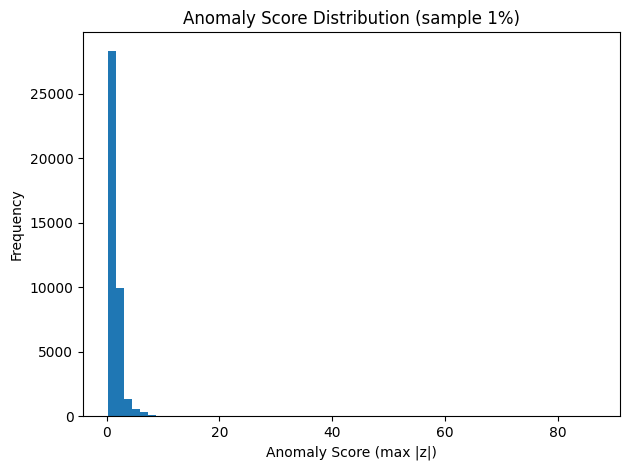

In [ ]:
import matplotlib.pyplot as plt

scores_pd = df_cur.select("anomaly_score").sample(False, 0.01, seed=42).toPandas()

plt.figure()
plt.hist(scores_pd["anomaly_score"], bins=60)
plt.title("Anomaly Score Distribution (sample 1%)")
plt.xlabel("Anomaly Score (max |z|)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


🟦 CELL 72 — Plot: Top 20 Anomalies by Score

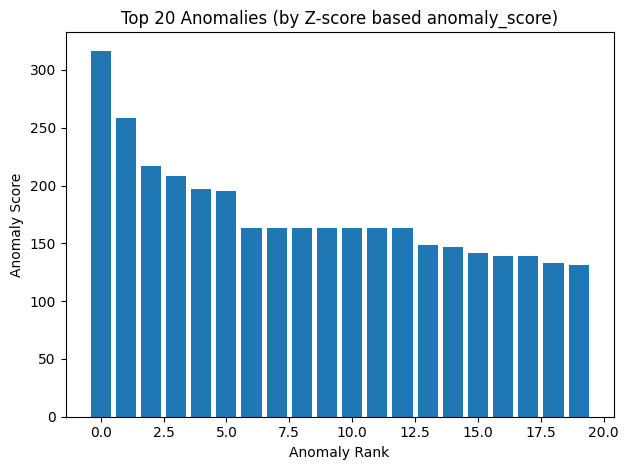

In [ ]:
top_pd = top_anomalies.toPandas().head(20)

plt.figure()
plt.bar(range(len(top_pd)), top_pd["anomaly_score"])
plt.title("Top 20 Anomalies (by Z-score based anomaly_score)")
plt.xlabel("Anomaly Rank")
plt.ylabel("Anomaly Score")
plt.tight_layout()
plt.show()


🟦 CELL 73 — Plot: Severity Among Anomalies

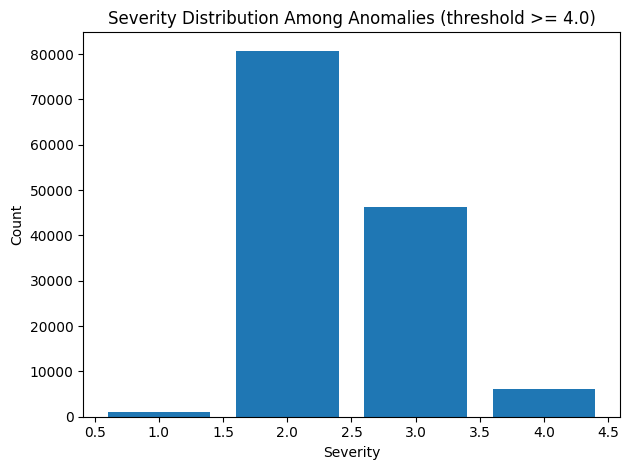

In [ ]:
anom_sev = anomalies.groupBy("Severity").count().orderBy("Severity").toPandas()

plt.figure()
plt.bar(anom_sev["Severity"], anom_sev["count"])
plt.title(f"Severity Distribution Among Anomalies (threshold >= {THRESHOLD})")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


🟦 CELL 74 — Save Anomalies Output (for report/ppt)

In [ ]:
ANOMALIES_OUT = "/content/anomalies_output_parquet"

anomalies.write.mode("overwrite").parquet(ANOMALIES_OUT)
print("Saved anomalies to:", ANOMALIES_OUT)


Saved anomalies to: /content/anomalies_output_parquet


🟦 CELL 75 — Part 6 Summary (Markdown)

# Part 6 Summary — Anomaly Detection

We implemented anomaly detection using Z-score on key numerical features.
Steps:
1) Compute mean and std for selected numeric columns
2) Compute z-scores per feature
3) Define anomaly_score = max(|z|) across features
4) Extract:
   - Top anomalies (highest anomaly_score)
   - Threshold-based anomalies (anomaly_score >= 4)

Deliverables:
- Anomalies table (top 50 + threshold-based)
- Charts:
  - Anomaly score distribution
  - Top anomalies by score
  - Severity distribution among anomalies
- Saved anomalies output to Parquet for reporting


🟦 CELL 76 — Part 7 Title (Markdown)

# Part 7 — Automation & Reporting

Goals:
1) Combine the workflow into an automated pipeline
2) Generate final reporting artifacts:
   - Key tables (CSV)
   - Key charts (PNG) for PowerPoint
   - Final summary metrics for the report


🟦 CELL 77 — Output Folders (create directories)

In [ ]:
import os

REPORT_DIR = "/content/report_outputs"
CHART_DIR  = f"{REPORT_DIR}/charts"
TABLE_DIR  = f"{REPORT_DIR}/tables"

os.makedirs(CHART_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

REPORT_DIR, CHART_DIR, TABLE_DIR


('/content/report_outputs',
 '/content/report_outputs/charts',
 '/content/report_outputs/tables')

🟦 CELL 78 — Helper: Save Spark DF to CSV

In [ ]:
def save_table_csv(spark_df, out_path_no_ext: str):
    # Spark writes CSV as folder with part files
    spark_df.coalesce(1).write.mode("overwrite").option("header", True).csv(out_path_no_ext)
    print("Saved CSV folder:", out_path_no_ext)


🟦 CELL 79 — Helper: Save Matplotlib Figure

In [ ]:
import matplotlib.pyplot as plt

def save_current_fig(filename: str):
    path = f"{CHART_DIR}/{filename}"
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    print("Saved chart:", path)


🟦 CELL 80 — Build a Single “Run Pipeline” Function

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def run_full_pipeline(
    raw_path: str,
    curated_parquet_path: str,
    view_name: str,
    anomaly_threshold: float = 4.0,
    seed: int = 42
):
    # -------------------------
    # Extract
    # -------------------------
    raw = (spark.read.option("header", True).option("inferSchema", True).csv(raw_path))

    # -------------------------
    # Transform (Part 2 + Part 5)
    # -------------------------
    df = raw.drop("End_Lat", "End_Lng")

    df = (df
          .withColumn("Hour", F.hour("Start_Time"))
          .withColumn("DayOfWeek", F.dayofweek("Start_Time"))
          .withColumn("Month", F.month("Start_Time")))

    # Impute numeric (median)
    num_cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Wind_Chill(F)"]
    medians = {}
    for c in num_cols:
        if c in df.columns:
            medians[c] = df.approxQuantile(c, [0.5], 0.01)[0]
    if medians:
        df = df.fillna(medians)

    # Fill categorical
    cat_cols = ["Weather_Condition","Wind_Direction","Sunrise_Sunset","Civil_Twilight",
                "Nautical_Twilight","Astronomical_Twilight"]
    df = df.fillna({c: "Unknown" for c in cat_cols if c in df.columns})

    # Drop rows missing essentials
    df = df.dropna(subset=["Severity", "Start_Time", "Start_Lat", "Start_Lng"])

    # Booleans to int
    bool_cols = ["Traffic_Signal","Crossing","Junction","Stop","Amenity","Railway","Roundabout","Station"]
    for c in bool_cols:
        if c in df.columns:
            df = df.withColumn(c, F.col(c).cast(IntegerType()))

    # Encode Weather_Condition
    indexer = StringIndexer(inputCol="Weather_Condition", outputCol="Weather_Condition_idx", handleInvalid="keep")
    df = indexer.fit(df).transform(df)

    encoder = OneHotEncoder(inputCol="Weather_Condition_idx", outputCol="Weather_Condition_vec")
    df = encoder.fit(df).transform(df)

    # Assemble features
    feature_cols = [
        "Distance(mi)","Temperature(F)","Humidity(%)","Pressure(in)","Visibility(mi)",
        "Wind_Speed(mph)","Precipitation(in)","Wind_Chill(F)",
        "Hour","DayOfWeek","Month",
        "Traffic_Signal","Crossing","Junction","Stop","Amenity","Railway","Roundabout","Station"
    ]
    feature_cols = [c for c in feature_cols if c in df.columns]

    assembler = VectorAssembler(inputCols=feature_cols + ["Weather_Condition_vec"], outputCol="features")
    df = assembler.transform(df)

    # Class weights
    total = df.count()
    dist = df.groupBy("Severity").count().collect()
    weights = {int(r["Severity"]): float(total)/float(r["count"]) for r in dist}
    weight_udf = F.udf(lambda x: float(weights[int(x)]), DoubleType())
    df = df.withColumn("classWeight", weight_udf(F.col("Severity")))

    # Load curated
    df.write.mode("overwrite").parquet(curated_parquet_path)
    curated = spark.read.parquet(curated_parquet_path)
    curated.createOrReplaceTempView(view_name)

    # -------------------------
    # Part 3 — SQL insights
    # -------------------------
    q_top_states = spark.sql(f"""
    SELECT State, COUNT(*) AS total_accidents
    FROM {view_name}
    GROUP BY State
    ORDER BY total_accidents DESC
    LIMIT 10
    """)

    q_by_hour = spark.sql(f"""
    SELECT Hour, COUNT(*) AS accidents_count
    FROM {view_name}
    WHERE Hour IS NOT NULL
    GROUP BY Hour
    ORDER BY Hour
    """)

    q_weather = spark.sql(f"""
    SELECT
      Weather_Condition,
      COUNT(*) AS total,
      ROUND(AVG(Severity), 3) AS avg_severity,
      ROUND(100.0 * SUM(CASE WHEN Severity >= 3 THEN 1 ELSE 0 END) / COUNT(*), 2) AS high_sev_pct
    FROM {view_name}
    WHERE Weather_Condition IS NOT NULL AND Weather_Condition <> 'Unknown'
    GROUP BY Weather_Condition
    HAVING COUNT(*) >= 5000
    ORDER BY total DESC
    LIMIT 12
    """)

    # -------------------------
    # Part 4 — Train/Eval
    # -------------------------
    train, test = curated.randomSplit([0.8, 0.2], seed=seed)

    lr = LogisticRegression(featuresCol="features", labelCol="Severity", weightCol="classWeight", maxIter=30)
    model = lr.fit(train)
    pred = model.transform(test)

    evals = {}
    for m in ["accuracy","weightedPrecision","weightedRecall","f1"]:
        evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName=m)
        evals[m] = evaluator.evaluate(pred)

    confusion = (pred.groupBy("Severity","prediction").count()
                 .orderBy("Severity","prediction"))

    # -------------------------
    # Part 6 — Anomalies (Z-score)
    # -------------------------
    z_cols = ["Distance(mi)","Precipitation(in)","Wind_Speed(mph)","Visibility(mi)",
              "Temperature(F)","Pressure(in)","Humidity(%)"]
    z_cols = [c for c in z_cols if c in curated.columns]

    stats_expr = []
    for c in z_cols:
        stats_expr += [F.mean(F.col(c)).alias(f"{c}__mean"), F.stddev(F.col(c)).alias(f"{c}__std")]
    stats = curated.select(*stats_expr).collect()[0].asDict()

    dfz = curated
    for c in z_cols:
        mu = stats.get(f"{c}__mean")
        sd = stats.get(f"{c}__std")
        if sd is None or sd == 0:
            dfz = dfz.withColumn(f"z_{c}", F.lit(0.0))
        else:
            dfz = dfz.withColumn(f"z_{c}", (F.col(c) - F.lit(mu)) / F.lit(sd))

    dfz = dfz.withColumn("anomaly_score", F.greatest(*[F.abs(F.col(f"z_{c}")) for c in z_cols]))
    anomalies = dfz.filter(F.col("anomaly_score") >= anomaly_threshold)
    top_anomalies = (dfz.select("ID","Severity","State","Start_Time",*z_cols,"anomaly_score")
                     .orderBy(F.desc("anomaly_score"))
                     .limit(50))

    # Return artifacts
    return {
        "curated": curated,
        "weights": weights,
        "q_top_states": q_top_states,
        "q_by_hour": q_by_hour,
        "q_weather": q_weather,
        "evals": evals,
        "confusion": confusion,
        "pred": pred,
        "anomalies": anomalies,
        "top_anomalies": top_anomalies
    }


🟦 CELL 81 — Run Pipeline

In [ ]:
art = run_full_pipeline(
    raw_path=RAW_PATH,
    curated_parquet_path=CURATED_PARQUET_PATH,
    view_name=SQL_VIEW_NAME,
    anomaly_threshold=4.0
)

art["evals"], art["weights"]


({'accuracy': 0.40001090042462106,
  'weightedPrecision': 0.7045132996164346,
  'weightedRecall': 0.4000109004246211,
  'f1': 0.44780455042622064},
 {3: 3.4217928689072794,
  1: 103.08255873340143,
  2: 1.46032689482475,
  4: 75.32164648368257})

🟦 CELL 82 — Save Key Tables (CSV)

In [ ]:
# 1) Severity distribution table
severity_table = spark.sql(f"""
SELECT Severity, COUNT(*) AS cnt
FROM {SQL_VIEW_NAME}
GROUP BY Severity
ORDER BY Severity
""")

save_table_csv(severity_table, f"{TABLE_DIR}/severity_distribution")

# 2) Top states
save_table_csv(art["q_top_states"], f"{TABLE_DIR}/top_states")

# 3) Accidents by hour
save_table_csv(art["q_by_hour"], f"{TABLE_DIR}/accidents_by_hour")

# 4) Weather table
save_table_csv(art["q_weather"], f"{TABLE_DIR}/weather_vs_severity")

# 5) Confusion matrix raw table
save_table_csv(art["confusion"], f"{TABLE_DIR}/confusion_matrix")

# 6) Top anomalies
save_table_csv(art["top_anomalies"], f"{TABLE_DIR}/top_anomalies")


Saved CSV folder: /content/report_outputs/tables/severity_distribution
Saved CSV folder: /content/report_outputs/tables/top_states
Saved CSV folder: /content/report_outputs/tables/accidents_by_hour
Saved CSV folder: /content/report_outputs/tables/weather_vs_severity
Saved CSV folder: /content/report_outputs/tables/confusion_matrix
Saved CSV folder: /content/report_outputs/tables/top_anomalies


🟦 CELL 83 — Charts: Severity Distribution (PNG)

Saved chart: /content/report_outputs/charts/01_severity_distribution.png


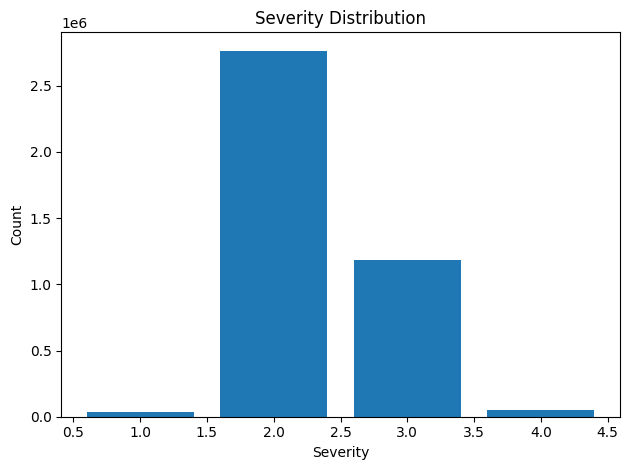

In [ ]:
import matplotlib.pyplot as plt

sev_pd = severity_table.toPandas()

plt.figure()
plt.bar(sev_pd["Severity"], sev_pd["cnt"])
plt.title("Severity Distribution")
plt.xlabel("Severity")
plt.ylabel("Count")
save_current_fig("01_severity_distribution.png")
plt.show()


🟦 CELL 84 — Charts: Top States (PNG)

Saved chart: /content/report_outputs/charts/02_top_states.png


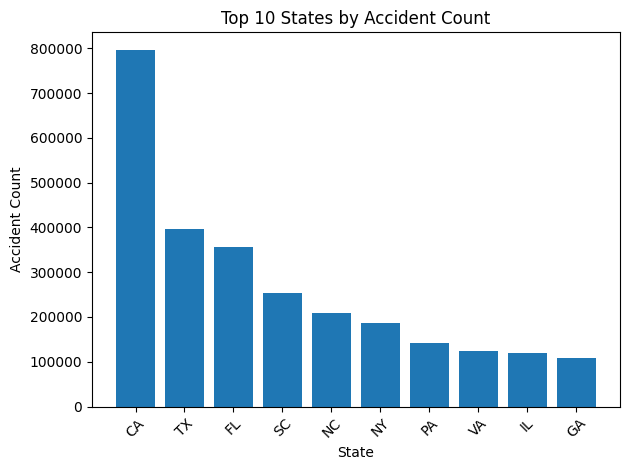

In [ ]:
top_states_pd = art["q_top_states"].toPandas()

plt.figure()
plt.bar(top_states_pd["State"], top_states_pd["total_accidents"])
plt.title("Top 10 States by Accident Count")
plt.xlabel("State")
plt.ylabel("Accident Count")
plt.xticks(rotation=45)
save_current_fig("02_top_states.png")
plt.show()


🟦 CELL 85 — Charts: Accidents by Hour (PNG)

Saved chart: /content/report_outputs/charts/03_accidents_by_hour.png


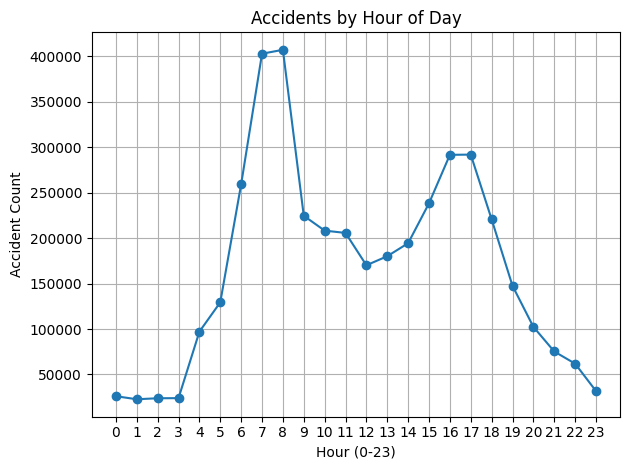

In [ ]:
hour_pd = art["q_by_hour"].toPandas()

plt.figure()
plt.plot(hour_pd["Hour"], hour_pd["accidents_count"], marker="o")
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour (0-23)")
plt.ylabel("Accident Count")
plt.xticks(range(0,24))
plt.grid(True)
save_current_fig("03_accidents_by_hour.png")
plt.show()


🟦 CELL 86 — Charts: Weather vs High Severity % (PNG)

Saved chart: /content/report_outputs/charts/04_weather_high_severity_pct.png


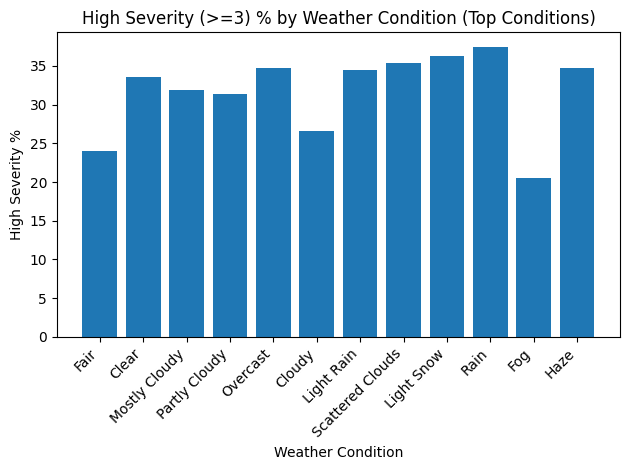

In [ ]:
weather_pd = art["q_weather"].toPandas()

plt.figure()
plt.bar(weather_pd["Weather_Condition"], weather_pd["high_sev_pct"])
plt.title("High Severity (>=3) % by Weather Condition (Top Conditions)")
plt.xlabel("Weather Condition")
plt.ylabel("High Severity %")
plt.xticks(rotation=45, ha="right")
save_current_fig("04_weather_high_severity_pct.png")
plt.show()


🟦 CELL 87 — Charts: Confusion Matrix Heatmap (PNG)

Saved chart: /content/report_outputs/charts/05_confusion_matrix.png


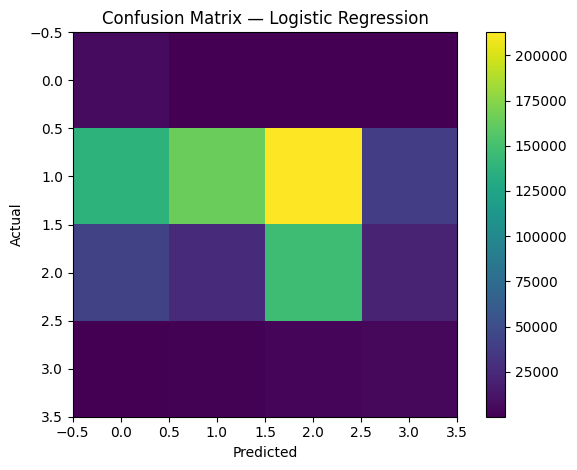

prediction,1.0,2.0,3.0,4.0
Severity,,,,
1,6589,432,657,99
2,137164,164461,212742,38656
3,41804,26374,146889,20919
4,882,1282,3365,4993


In [ ]:
import pandas as pd

cm_pd = art["confusion"].toPandas()
pivot = cm_pd.pivot(index="Severity", columns="prediction", values="count").fillna(0)

plt.figure()
plt.imshow(pivot)
plt.colorbar()
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
save_current_fig("05_confusion_matrix.png")
plt.show()

pivot


🟦 CELL 88 — Charts: Anomaly Score Distribution (PNG)

Saved chart: /content/report_outputs/charts/06_distance_distribution.png


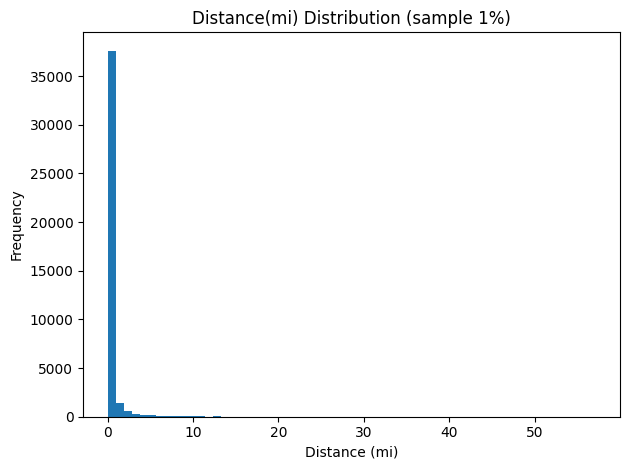

In [ ]:
scores_pd = art["curated"].select("Distance(mi)").sample(False, 0.01, seed=42).toPandas()

# We will reuse anomaly scores from the pipeline by recomputing quickly from anomalies output
# For a simple slide-friendly chart: show distribution of Distance(mi) as a proxy for outliers

plt.figure()
plt.hist(scores_pd["Distance(mi)"], bins=60)
plt.title("Distance(mi) Distribution (sample 1%)")
plt.xlabel("Distance (mi)")
plt.ylabel("Frequency")
save_current_fig("06_distance_distribution.png")
plt.show()


🟦 CELL 89 — Final Metrics Summary (Markdown block for report)

In [ ]:
evals = art["evals"]
weights = art["weights"]

summary_text = f"""
MODEL: Logistic Regression (Spark MLlib) with class weights

Evaluation Metrics:
- Accuracy: {evals['accuracy']:.4f}
- Weighted Precision: {evals['weightedPrecision']:.4f}
- Weighted Recall: {evals['weightedRecall']:.4f}
- F1-score: {evals['f1']:.4f}

Class Weights (to handle imbalance):
{weights}

Saved Outputs:
- Tables (CSV folders): {TABLE_DIR}
- Charts (PNG): {CHART_DIR}
- Curated Parquet: {CURATED_PARQUET_PATH}
"""

print(summary_text)



MODEL: Logistic Regression (Spark MLlib) with class weights

Evaluation Metrics:
- Accuracy: 0.4000
- Weighted Precision: 0.7045
- Weighted Recall: 0.4000
- F1-score: 0.4478

Class Weights (to handle imbalance):
{3: 3.4217928689072794, 1: 103.08255873340143, 2: 1.46032689482475, 4: 75.32164648368257}

Saved Outputs:
- Tables (CSV folders): /content/report_outputs/tables
- Charts (PNG): /content/report_outputs/charts
- Curated Parquet: /content/curated_us_accidents_parquet



🟦 CELL 90 — Part 7 Final Summary (Markdown)

# Part 7 Summary — Automation & Reporting

We built a single automated pipeline that runs end-to-end:
- Extract raw CSV
- Transform (cleaning, feature engineering, encoding, vector assembly, class weights)
- SQL analytics queries + charts
- Train/evaluate classification model
- Perform anomaly detection
- Save reporting artifacts for the report and PowerPoint (CSV + PNG)

Deliverables generated in:
- `/content/report_outputs/tables`  (CSV tables)
- `/content/report_outputs/charts`  (PNG charts)


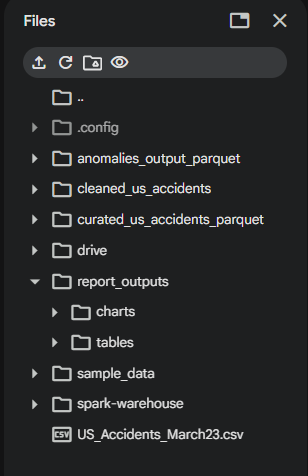